In [1]:
# Gradienty - idee głównie z:
# https://arxiv.org/pdf/1609.04747.pdf
# https://d2l.ai/chapter_optimization/index.html

#Wnioski (błąd - MSE - metryki przeanalizuję na innym neuralu):
# 1) Zwykły SGD - do 0.035, niezależnie od liczby prób - szybki, 150s/10000i
# 2) Momentum - do 0.025, 110.000 prób - szybki, 160s/10000i
# 3) Nestorov - szybciej zbiega(0.028 - 60.000), zajebiście wolny, 240s/10000i
# 4) AdaGrad - zbiega nawet szybciej z lr=0.1 (0.03 - 40.000), później beton nie do ruszenia (sum > 10e5), szybki
# 5) RMSEProp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist
import setuptools
%load_ext Cython

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

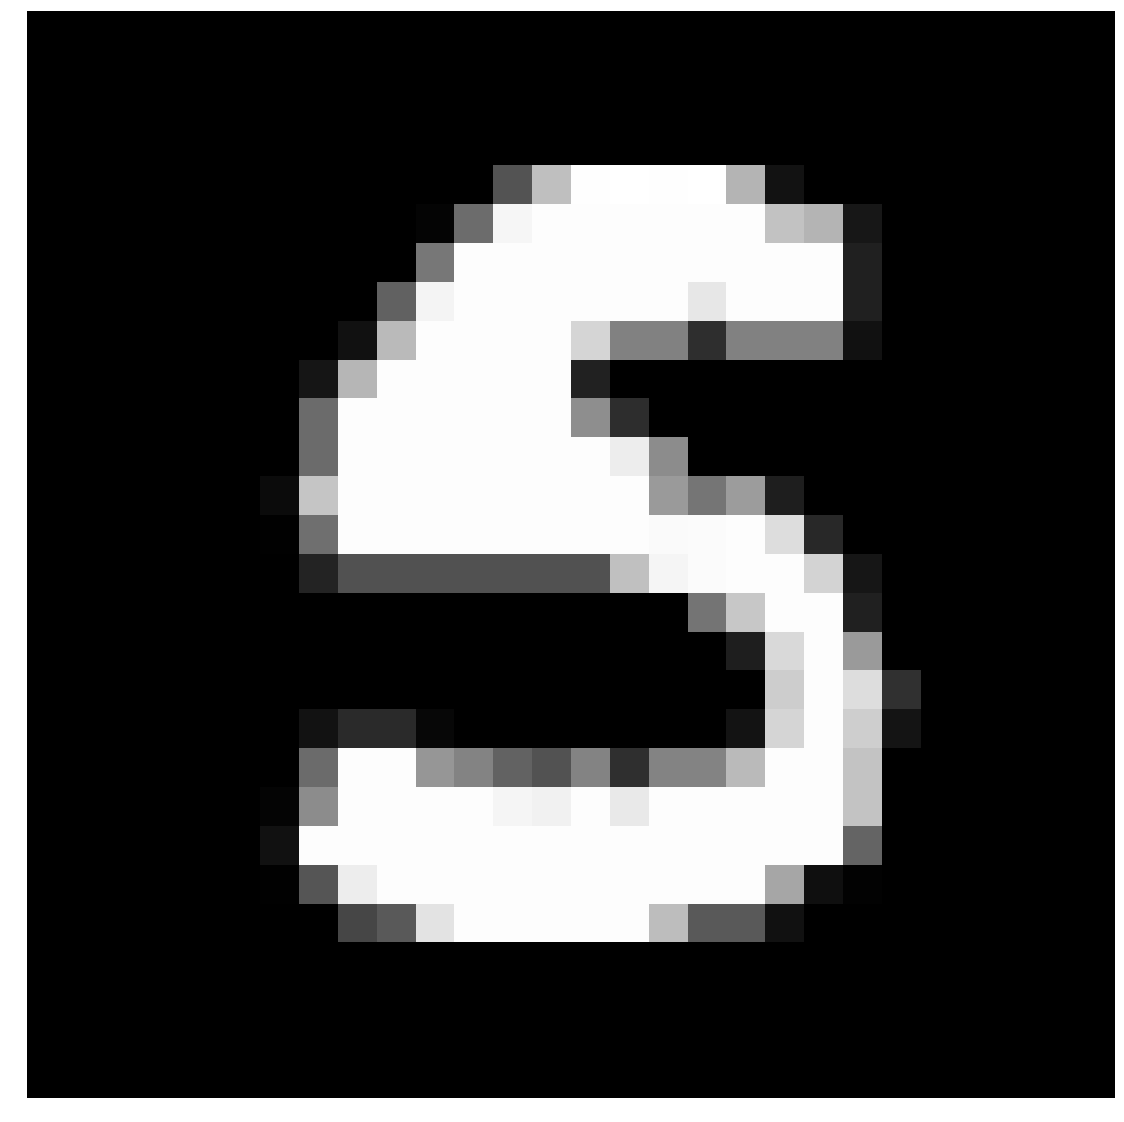

In [2]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

def supdisp(X, ax=None, titel=''):
    charred_bloodbirds_escape_from_the_ruins=0
    if (ax==None):
        charred_bloodbirds_escape_from_the_ruins=1
        fig, ax=plt.subplots(1,1,figsize=(20,20))
    Y=X.copy()
    
    zz1=Y.copy()
    Y=np.append(Y, zz1, axis=2)
    Y=np.append(Y, zz1, axis=2)
    
    ax.imshow(Y)
    ax.set_title(titel)
    ax.axis('off')
    if (charred_bloodbirds_escape_from_the_ruins==1):
        plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [15]:
def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0

def relu_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def relu_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def sigm_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigm_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def tanh_forw(v):
    return np.asmatrix(np.apply_along_axis(math.tanh, 1, v).reshape(v.shape[0], 1))

def tanh_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: (1+math.tanh(x))*(1-math.tanh(x)), 1, v).reshape(v.shape[0], 1))

#Archetypy zmiennych: nn_delta - learning rate, grad - gradient

#weight_delta - stara zmienna do agregacji
def momentum_gradient(momentum, weight_delta, nn_delta, grad):
    return momentum*weight_delta+nn_delta*grad

def sgd_gradient(nn_delta, grad):
    return nn_delta*grad

#pale_companion - zmienna do agregacji, eps - epsilon(żeby nie dzielić przez 0)
def adagrad_gradient(pale_companion, nn_delta, grad, eps=0.0000001):
    pale_companion+=np.multiply(grad, grad)
    return np.multiply((nn_delta/np.sqrt(pale_companion+eps)), grad)
#Momentum - tutaj miara decaya
def RMSProp_gradient(pale_companion, nn_delta, grad, momentum=0.9, eps=0.0000001):
    pale_companion=momentum*pale_companion+(1-momentum)*np.multiply(grad, grad)
    return np.multiply((nn_delta/np.sqrt(pale_companion+eps)), grad)

# Fun - funkcja backpropagacji, mwd - iloczyn momentum i ostatniej delty wagi, derivative - pochodna z następnego layera,
# out_last - poprzedni out, weight, - waga
def nestorov_accelerated_gradient(fun, mwd, weight, out_last, derivative, nn_delta):
    sdel=np.multiply(fun((weight-mwd)*out_last),derivative)
    return mwd+nn_delta*(sdel*out_last.T)

In [100]:
#Ustawianie parametrów
#Rozdział ustawienia parametrów i neurala - pozwala mi na wznowiecie nauki neurala bez zapisu outów

#Wagi, biasy, delty wag/biasów
w=[0]*10
bw=[0]*10
weight_delta=[0]*10
summerland=[0]*10
bias_delta=[0]*10

#Tymczasowe zmienne do trzymania outów i pochodnych po backpropagosie
act=[0]*10
wact=[0]*10
back_p=[0]*10
#lyrning rejt
nn_delta=0.01
#Funkcje wykonywane przez warstwy, warstwy - logic (bez 1-wszej: input)[rozmiar k-tej warstwy od 1]
lst=28*28
logic=[50,20,50,lst]
fforw=[sigm_forw, sigm_forw, sigm_forw, sigm_forw]
fback=[sigm_back, sigm_back, sigm_back, sigm_back]
momentum=0.9
eps=0.00000001
ll=len(logic)

#Determinacja wag i biasów
for i in range(ll):
    w[i]=np.asmatrix([0.15*np.random.normal(0, 1) for j in range(lst*logic[i])]).reshape(logic[i], lst)
    weight_delta[i]=np.zeros((logic[i], lst))
    summerland[i]=np.zeros((logic[i], lst))
    bw[i]=0.15*np.random.normal(0, 1)
    lst=logic[i]

In [84]:
#Poligon doświadczalny do różnych gradientów

#iteracje, epoki, zapis wyniku do wykresu
iterr=1000
epokz=1
aedificator_mundi_carcerem=[0]*(iterr*epokz)

for ii in range(epokz):
    t1=time.time()
    for i in range(iterr):
        img=trainX[i].copy()
        img=img/255
        img=img.reshape(img.shape[0]*img.shape[1],1)

        wact[0]=np.asmatrix(img.copy())
        for j in range(1, ll+1):
            act[j]=w[j-1]*wact[j-1]#+bw[j-1]
            wact[j]=fforw[j-1](act[j])

        ####  Kost
        kgb=np.asarray(img)-np.asarray(wact[ll])
        der=-2*kgb
        kgb=kgb*kgb
        s=(sum(kgb)/len(kgb))
        s=s[0]
        aedificator_mundi_carcerem[iterr*ii+i]=s
        ####

        #kar=np.asarray(wact[ll]).reshape(trainX[i].shape[0], trainX[i].shape[1], 1)
        #supdisp(kar)

        back_p[ll+1]=der
        for j in range(ll,0,-1):
            #Nestorov dla biedaków - nie mam pojęcia, czy poprawnie, ale wyniki są wysoce satysfakcjonujące
            
            #weight_delta[j-1]=nestorov_accelerated_gradient(fback[j-1], momentum*weight_delta[j-1], w[j-1], wact[j-1], back_p[j+1], nn_delta) ##Nestorov      
            sdel=np.multiply(fback[j-1](act[j]),back_p[j+1])
            
            #weight_delta[j-1]=RMSProp_gradient(summerland[j-1], 0.001, sdel*wact[j-1].T, 0.9, eps) ##RMSProp
            weight_delta[j-1]=adagrad_gradient(summerland[j-1], nn_delta, sdel*wact[j-1].T, eps) ##AdaGrad
            #weight_delta[j-1]=momentum_gradient(momentum, weight_delta[j-1], nn_delta, sdel*wact[j-1].T) ##Momentum
            #weight_delta[j-1]=sgd_gradient(nn_delta, (sdel*wact[j-1].T)) ##SGD
            
            #bias_delta[j-1]=sum(sdel)[0,0]/len(sdel)
            back_p[j]=w[j-1].T*sdel

        for j in range(ll):
            w[j]-=weight_delta[j]
            #bw[j]-=bias_delta[j]*nn_delta
    t2=time.time()
    print(t2-t1)

18.033631801605225


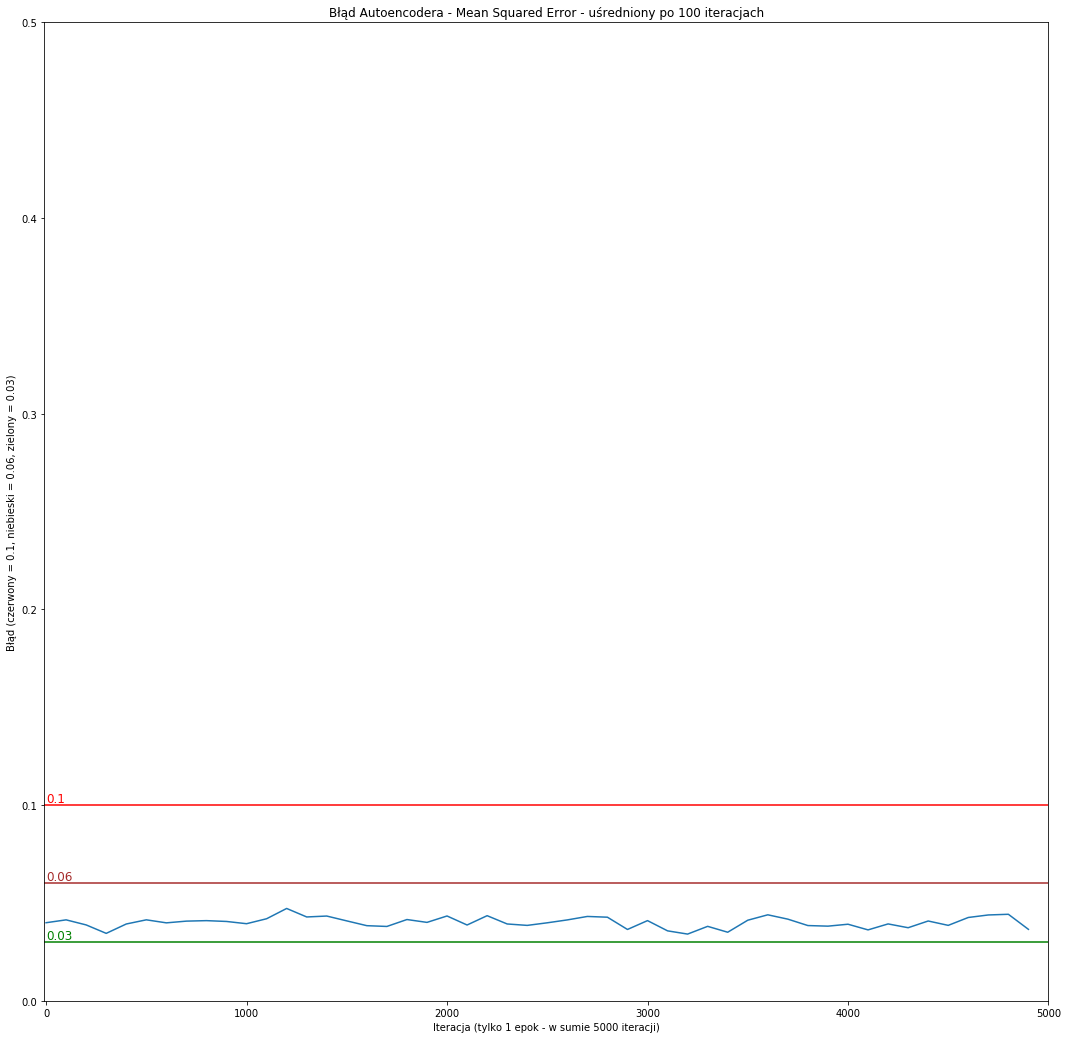

In [99]:
fig, ax=plt.subplots(1, 1, figsize=(18,18))
#dt - liczba iteracji, kgbo - uśrednienie błędu po tylu iteracjach, ss- parametr labeli
dt=iterr*epokz
kgbo=100
dt2=dt//kgbo
ss=10

#Formulacja średnich
dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(aedificator_mundi_carcerem[i*kgbo:(i+1)*kgbo])/kgbo

alpha, beta, gamma=0.1,0.06,0.03

ax.set_title('Błąd Autoencodera - Mean Squared Error - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko {} epok - w sumie {} iteracji)'.format(epokz, dt))
ax.set_xticklabels(range(0, dt+1, kgbo*ss))
ax.set_xticks(range(0, dt//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = {}, niebieski = {}, zielony = {})'.format(alpha, beta, gamma))
ax.axhline(alpha, color='red')
ax.axhline(beta, color='brown')
ax.axhline(gamma, color='green')
ax.plot(dkkk)
ax.text(x=0, y=alpha, s='{}'.format(alpha), verticalalignment='bottom', horizontalalignment='left', color='red', size=12)
ax.text(x=0, y=beta, s='{}'.format(beta), verticalalignment='bottom', horizontalalignment='left', color='brown', size=12)
ax.text(x=0, y=gamma, s='{}'.format(gamma), verticalalignment='bottom', horizontalalignment='left', color='green', size=12)
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.1, dt2)
plt.show()

3.57120418548584


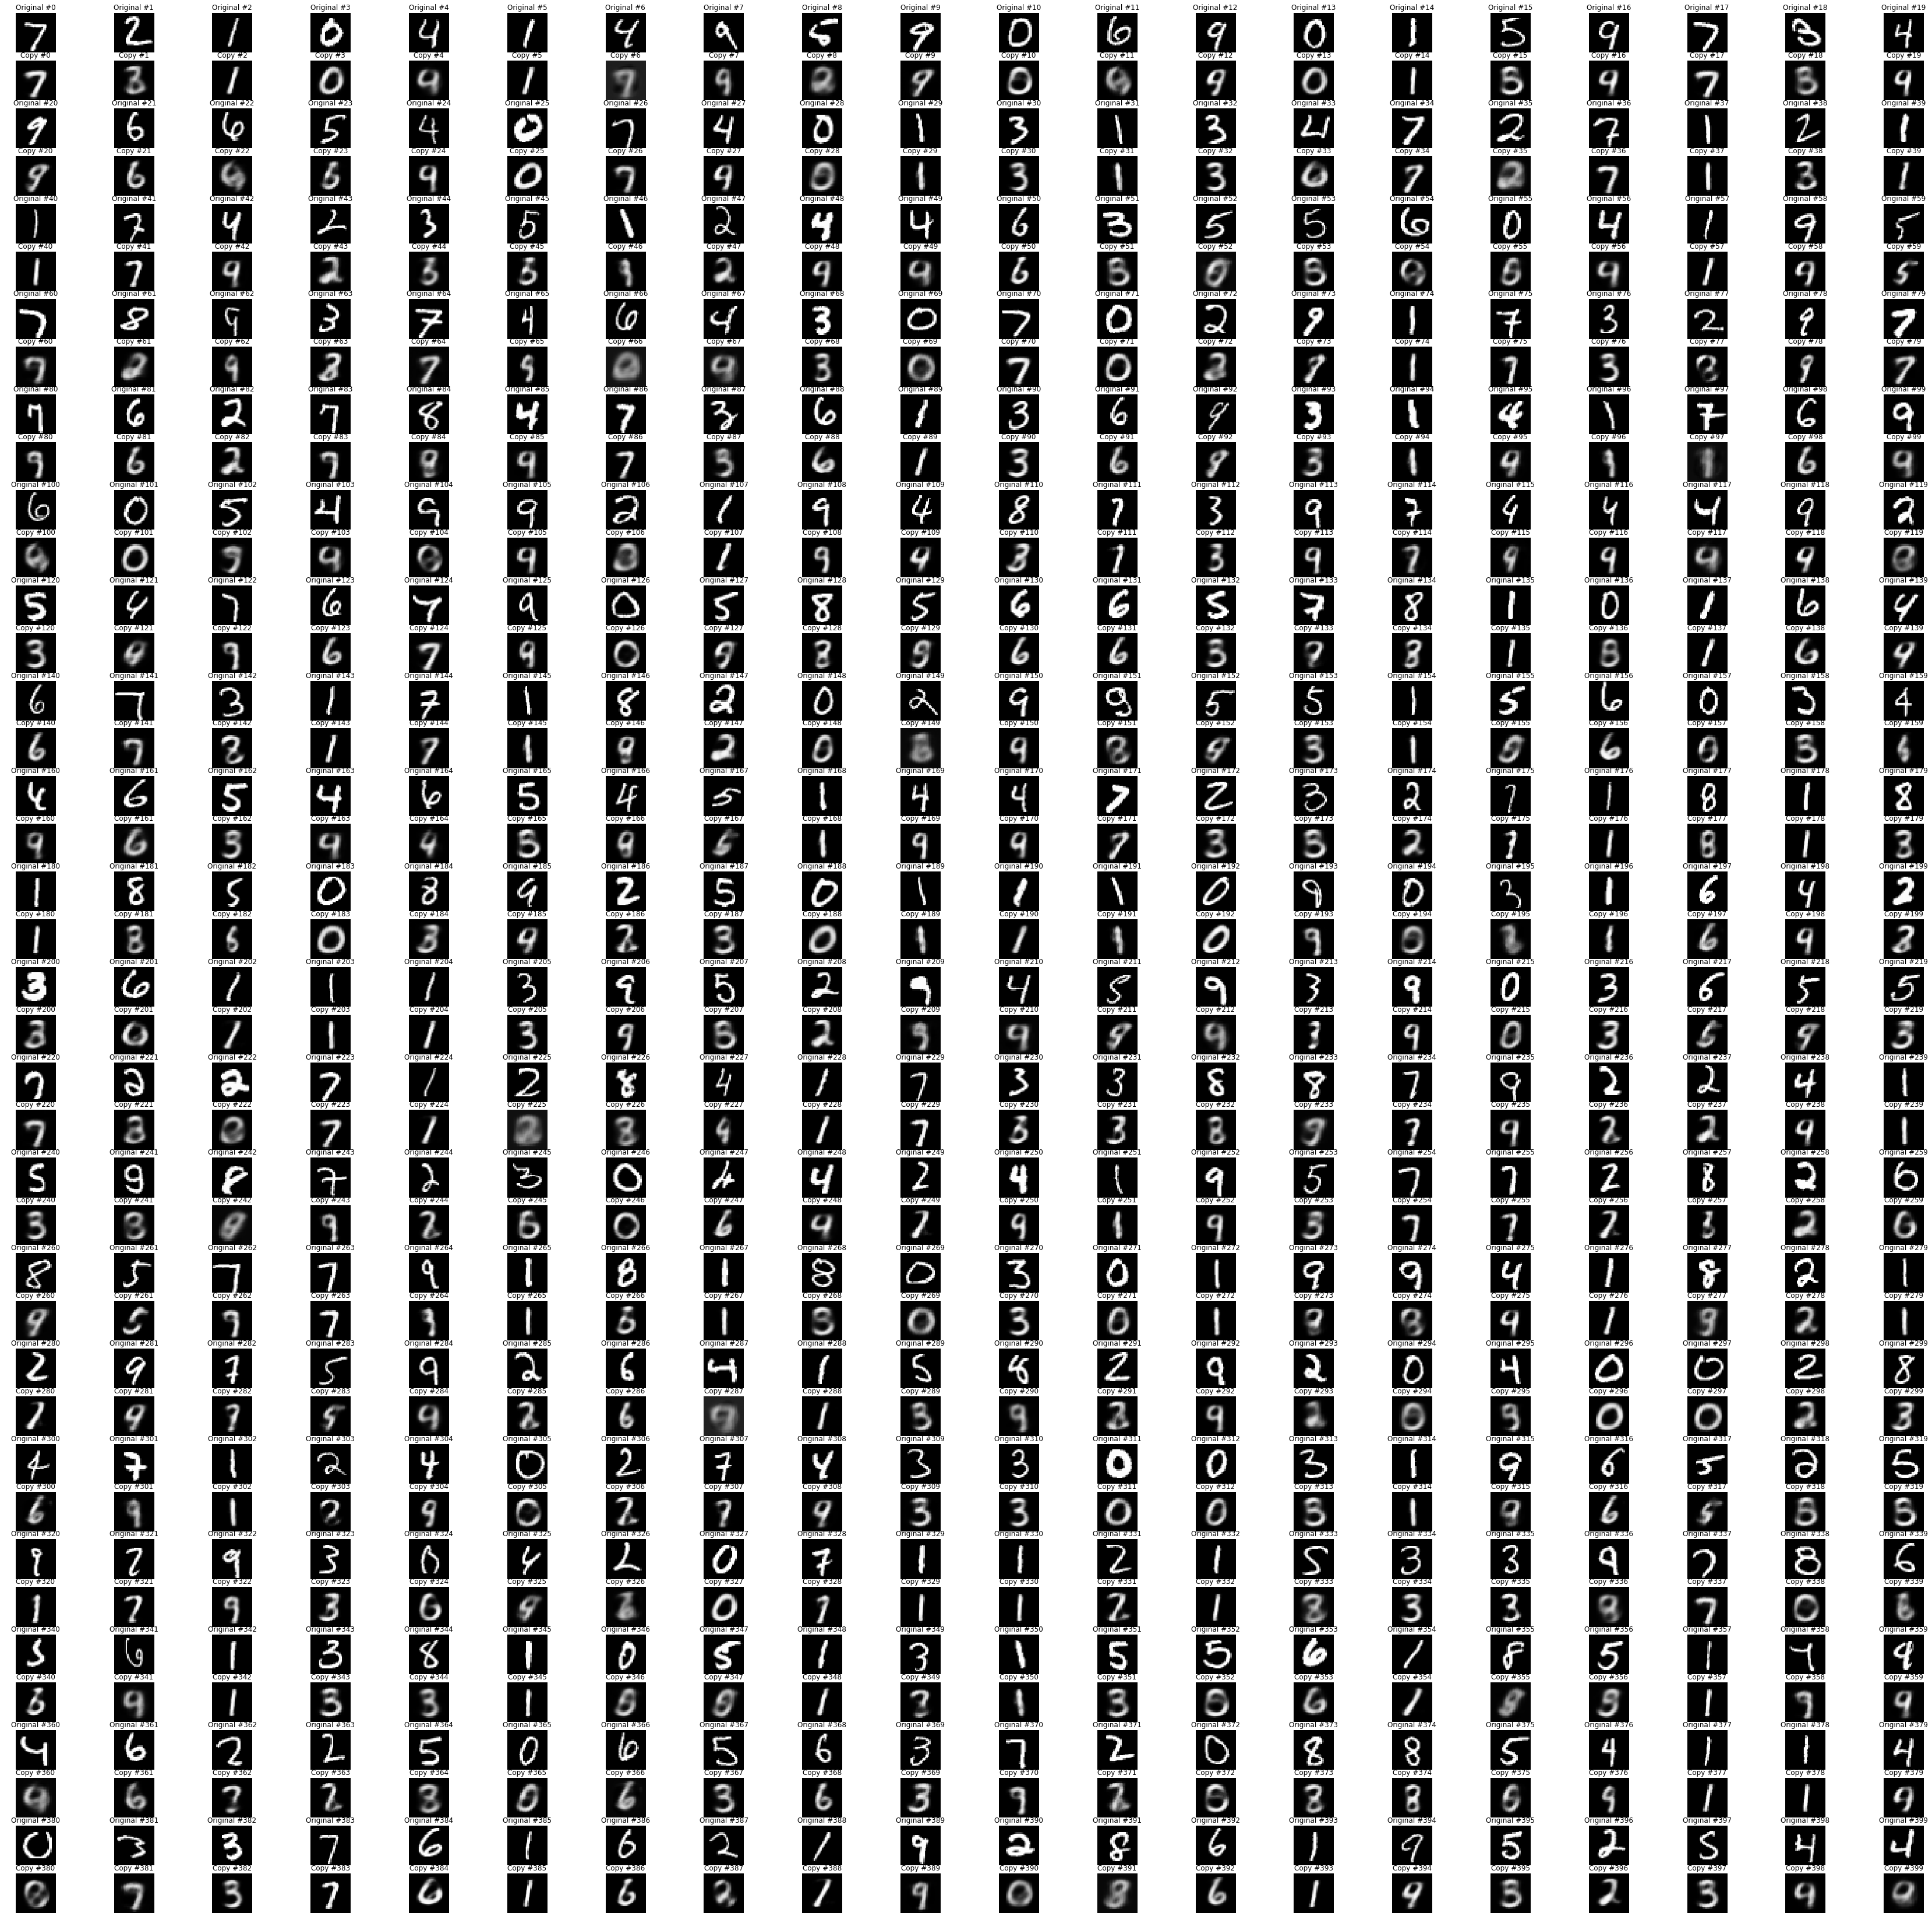

In [112]:
#Wizualifikacja niezwizualizowanego
#Liczba obrazków z testu
iterr=400

act=[0]*10
wact=[0]*10
ggout=[0]*iterr
#Tworze wykres
asqrt=math.ceil(math.sqrt(iterr))
fig, ax=plt.subplots(2*asqrt, asqrt, figsize=(asqrt*3,asqrt*3))

t1=time.time()
for i in range(iterr):
    img=testX[i].copy()
    img=img/255
    img=img.reshape(img.shape[0]*img.shape[1],1)

    wact[0]=np.asmatrix(img.copy())
    for j in range(1, ll+1):
        act[j]=w[j-1]*wact[j-1]#+bw[j-1]
        wact[j]=fforw[j-1](act[j])

    ####  Kost
    kgb=np.asarray(img)-np.asarray(wact[ll])
    kgb=kgb*kgb
    s=(sum(kgb)/len(kgb))
    s=s[0]
    ggout[i]=s
    ####
    
    supdisp(testX[i].reshape(testX[i].shape[0], testX[i].shape[1], 1), ax[2*(i//asqrt)][i%asqrt], 'Original #{}'.format(i))
    kar=np.asarray(wact[ll]).reshape(testX[i].shape[0], testX[i].shape[1], 1)
    supdisp(kar, ax[2*(i//asqrt)+1][i%asqrt], 'Copy #{}'.format(i))
t2=time.time()
print(t2-t1)
plt.show()

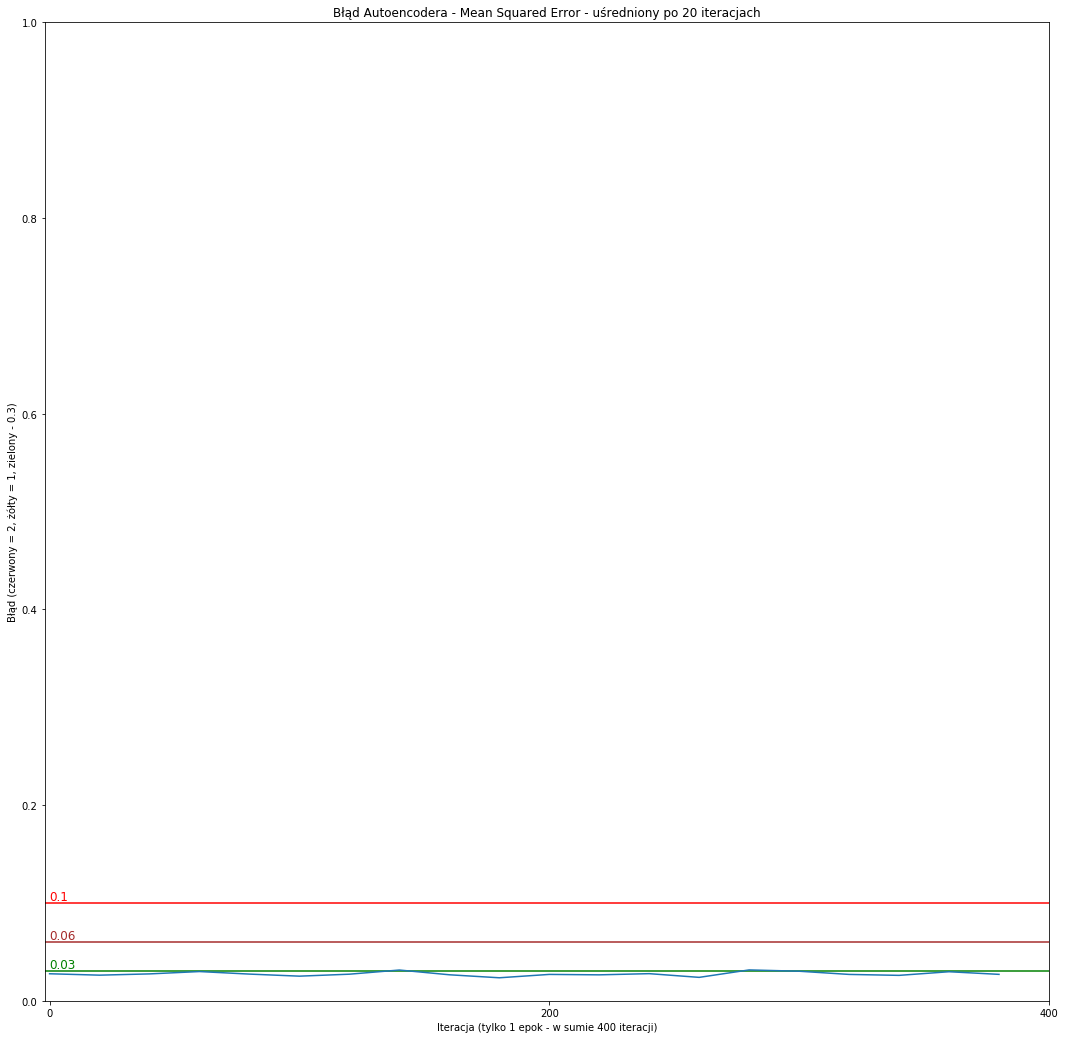

In [14]:
#Wynikowy set - błąd
fig, ax=plt.subplots(1, 1, figsize=(18,18))
#dt - liczba iteracji, kgbo - uśrednienie błędu po tylu iteracjach, ss- parametr labeli
dt=iterr
kgbo=20
dt2=dt//kgbo
ss=10

#Formulacja średnich
dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(ggout[i*kgbo:(i+1)*kgbo])/kgbo

alpha, beta, gamma=0.1,0.06,0.03

ax.set_title('Błąd Autoencodera - Mean Squared Error - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko {} epok - w sumie {} iteracji)'.format(epokz, dt))
ax.set_xticklabels(range(0, dt+1, kgbo*ss))
ax.set_xticks(range(0, dt//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1, zielony - 0.3)')
ax.axhline(alpha, color='red')
ax.axhline(beta, color='brown')
ax.axhline(gamma, color='green')
ax.plot(dkkk)
ax.text(x=0, y=alpha, s='{}'.format(alpha), verticalalignment='bottom', horizontalalignment='left', color='red', size=12)
ax.text(x=0, y=beta, s='{}'.format(beta), verticalalignment='bottom', horizontalalignment='left', color='brown', size=12)
ax.text(x=0, y=gamma, s='{}'.format(gamma), verticalalignment='bottom', horizontalalignment='left', color='green', size=12)
ax.set_ylim(0, 1)
ax.set_xlim(-0.1, dt2)
plt.show()

In [9]:
#Ustawianie parametrów
#Rozdział ustawienia parametrów i neurala - pozwala mi na wznowiecie nauki neurala bez zapisu outów

#Wagi, biasy, delty wag/biasów
w=[0]*10
bw=[0]*10
weight_delta=[0]*10
summerland=[0]*10
bias_delta=[0]*10

#Tymczasowe zmienne do trzymania outów i pochodnych po backpropagosie
act=[0]*10
wact=[0]*10
back_p=[0]*10
#Funkcje wykonywane przez warstwy, warstwy - logic (bez 1-wszej: input)[rozmiar k-tej warstwy od 1]
lst=28*28
logic=[50,20,50,lst]
fforw=[sigm_forw, sigm_forw, sigm_forw, sigm_forw]
fback=[sigm_back, sigm_back, sigm_back, sigm_back]
eps=0.00000001
ll=len(logic)

In [85]:
funlist=[nestorov_accelerated_gradient, sgd_gradient, momentum_gradient, RMSProp_gradient, adagrad_gradient]
rfun=[10**i for i in range(-4,1)]+[5*10**i for i in range(-5,0)]
iterr=10000
epokz=1
lr, lf=len(rfun), len(funlist)
aedificator_mundi_carcerem=[0]*(iterr*epokz*lr*lf)

mydick={'nn_delta':'nn_delta', 'eps':'eps', 'momentum':'momentum', 'grad':'(sdel*wact[j-1].T)',
        'weight_delta':'weight_delta[j-1]', 'pale_companion':'summerland[j-1]', 'fun':'fback[j-1]',  
        'mwd':'momentum*weight_delta[j-1]', 'weight':'w[j-1]', 'out_last':'wact[j-1]', 'derivative':'back_p[j+1]'}

for i1 in range(lf):
    argnamez=funlist[i1].__code__.co_varnames[:funlist[i1].__code__.co_argcount]
    print(argnamez)
    for i2 in range(lr):
        
        #Hyperparameter tuning
        nn_delta=rfun[i2]
        momentum=0.9

        #Determinacja wag i biasów
        for i in range(ll):
            w[i]=np.asmatrix([0.15*np.random.normal(0, 1) for j in range(lst*logic[i])]).reshape(logic[i], lst)
            weight_delta[i]=np.zeros((logic[i], lst))
            summerland[i]=np.zeros((logic[i], lst))
            bw[i]=0.15*np.random.normal(0, 1)
            lst=logic[i]

        for ii in range(epokz):
            t1=time.time()
            for i in range(iterr):
                img=trainX[i].copy()
                img=img/255
                img=img.reshape(img.shape[0]*img.shape[1],1)

                wact[0]=np.asmatrix(img.copy())
                for j in range(1, ll+1):
                    act[j]=w[j-1]*wact[j-1]#+bw[j-1]
                    wact[j]=fforw[j-1](act[j])

                ####  Kost
                kgb=np.asarray(img)-np.asarray(wact[ll])
                der=-2*kgb
                kgb=kgb*kgb
                s=(sum(kgb)/len(kgb))
                s=s[0]
                aedificator_mundi_carcerem[lr*epokz*iterr*i1+epokz*iterr*i2+iterr*ii+i]=s
                ####

                #kar=np.asarray(wact[ll]).reshape(trainX[i].shape[0], trainX[i].shape[1], 1)
                #supdisp(kar)

                back_p[ll+1]=der
                for j in range(ll,0,-1):
                    sdel=np.multiply(fback[j-1](act[j]),back_p[j+1])
                    nwlst=[]
                    for jj in range(len(argnamez)):
                        exec('nwlst.append({})'.format(mydick[argnamez[jj]]))
                    weight_delta[j-1]=funlist[i1](*nwlst)
                    
                    #bias_delta[j-1]=sum(sdel)[0,0]/len(sdel)
                    back_p[j]=w[j-1].T*sdel

                for j in range(ll):
                    w[j]-=weight_delta[j]
                    #bw[j]-=bias_delta[j]*nn_delta
            t2=time.time()
            print(t2-t1)

('fun', 'mwd', 'weight', 'out_last', 'derivative', 'nn_delta')
282.5818965435028
275.1064832210541
275.3248836994171
275.8104844093323
276.30768513679504
275.2624833583832
274.7788825035095
275.57448387145996
279.21329045295715
281.9246952533722
('nn_delta', 'grad')
177.9438018798828
180.1930079460144
178.69526720046997
177.48151183128357
177.63751220703125
178.62231373786926
178.55791354179382
181.01111817359924
178.99771428108215
179.54071521759033
('momentum', 'weight_delta', 'nn_delta', 'grad')
186.49932742118835
181.33471846580505
179.72791576385498
180.5713174343109
179.9161159992218
179.91511607170105
178.91671419143677
179.68111562728882
180.07111597061157
179.9931161403656
('pale_companion', 'nn_delta', 'grad', 'momentum', 'eps')
183.64352250099182
183.64352250099182
186.2992136478424
183.1453218460083
186.3590099811554
186.35792708396912
190.13413381576538
188.63513469696045
183.75372290611267
185.2503252029419
('pale_companion', 'nn_delta', 'grad', 'eps')
183.05072140693665


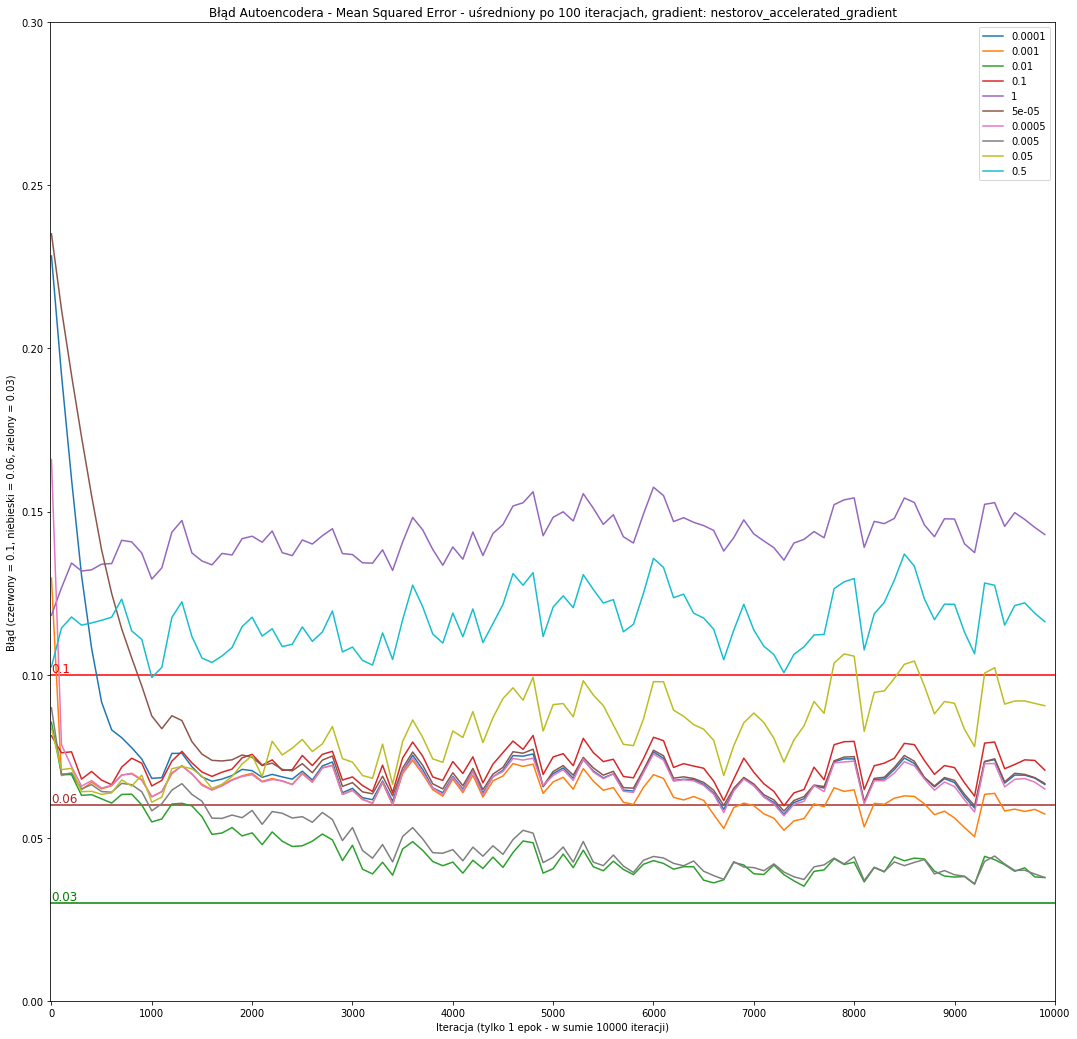

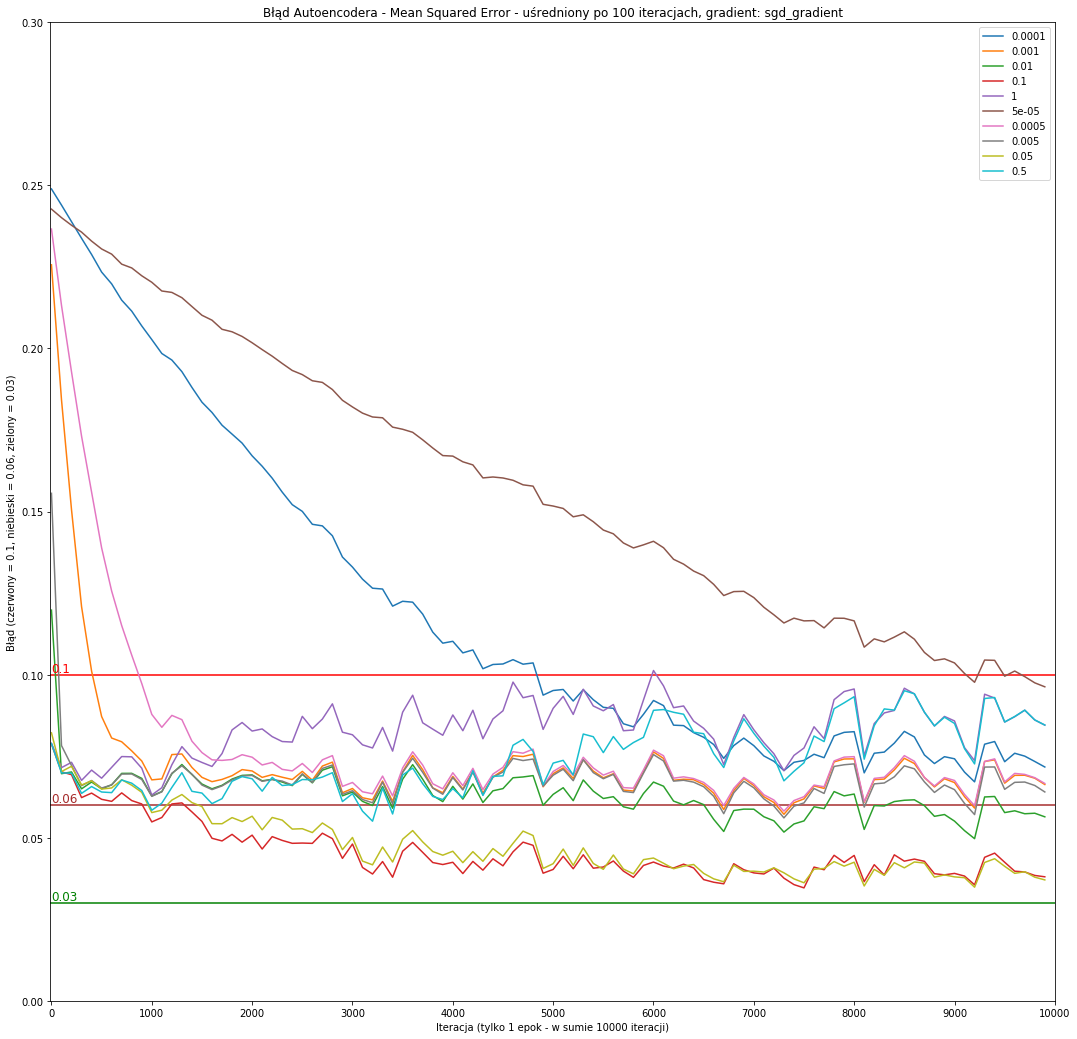

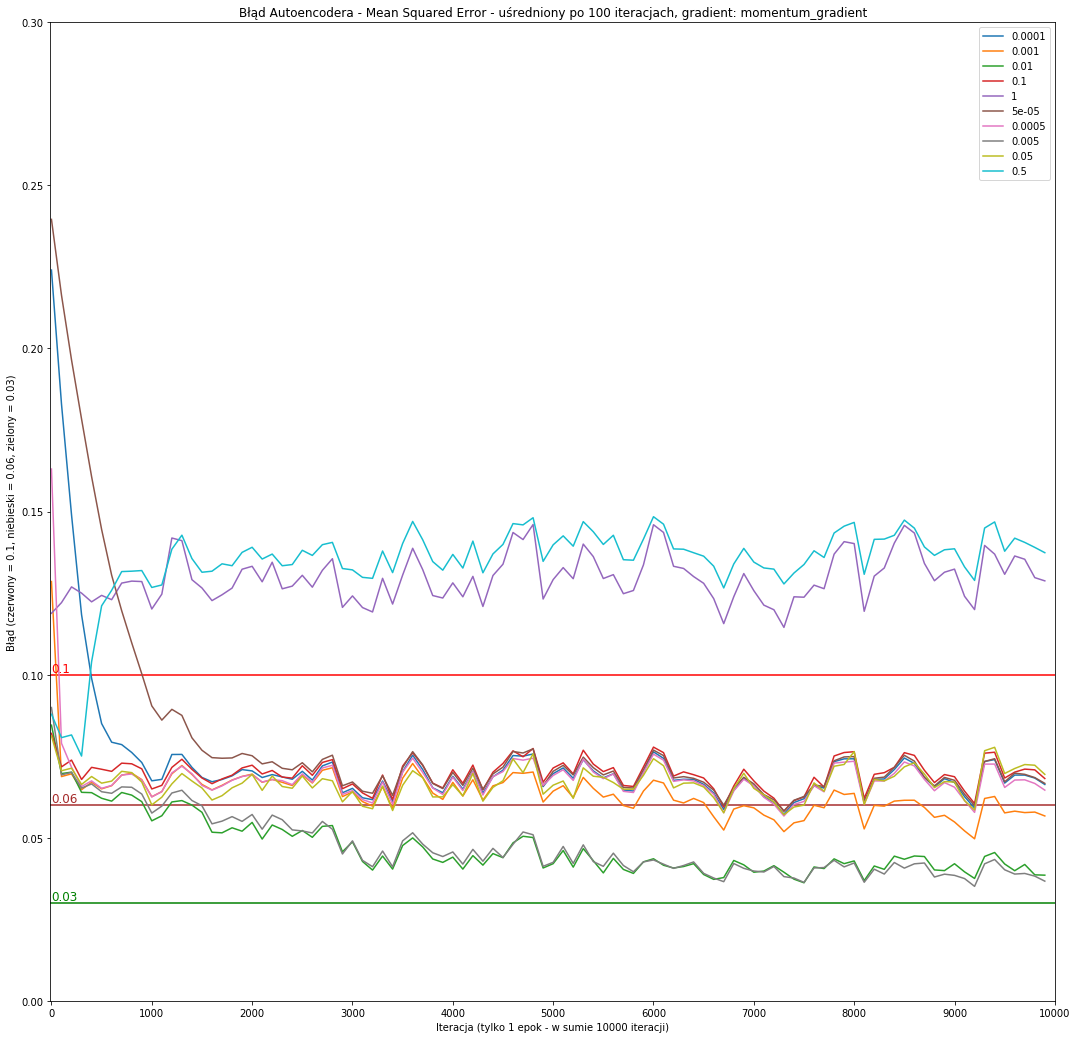

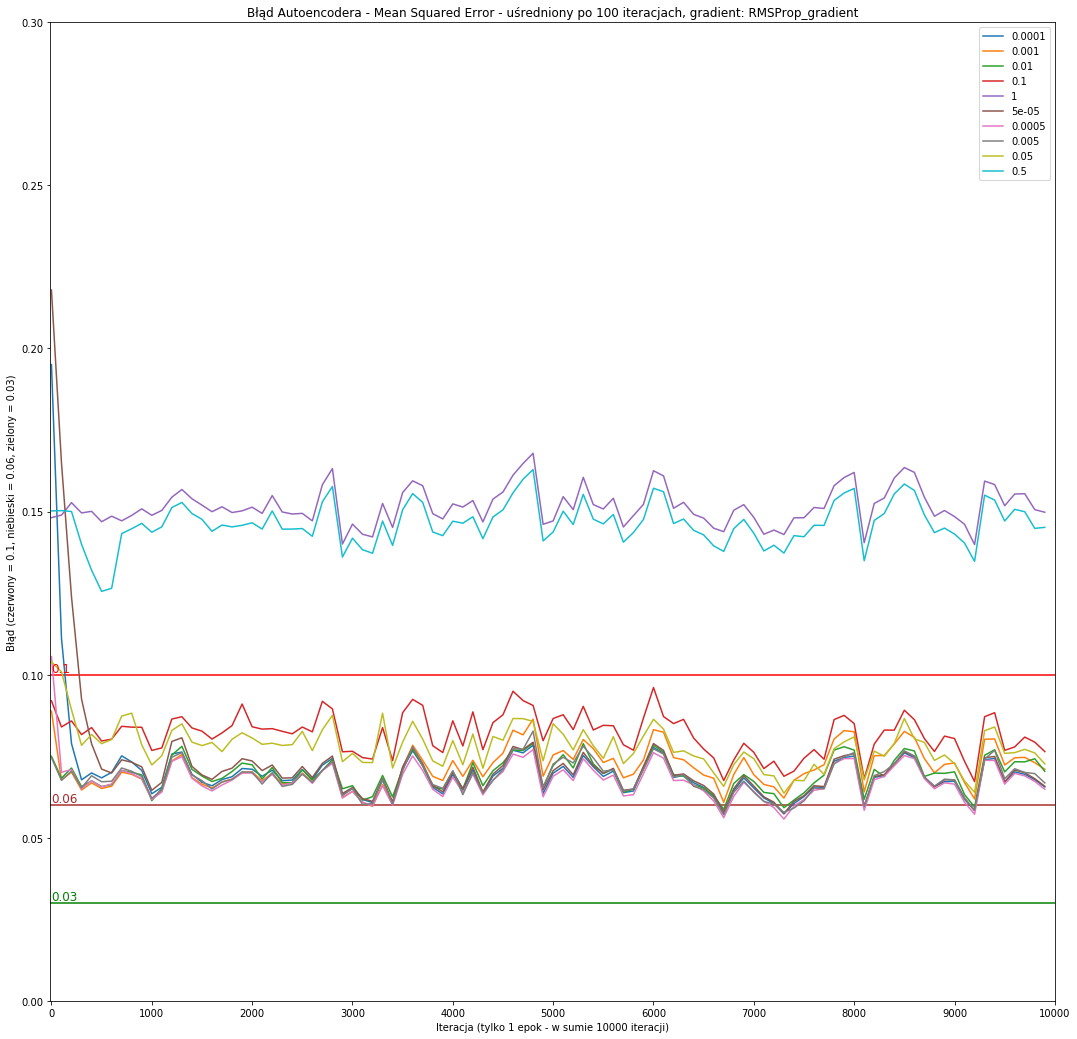

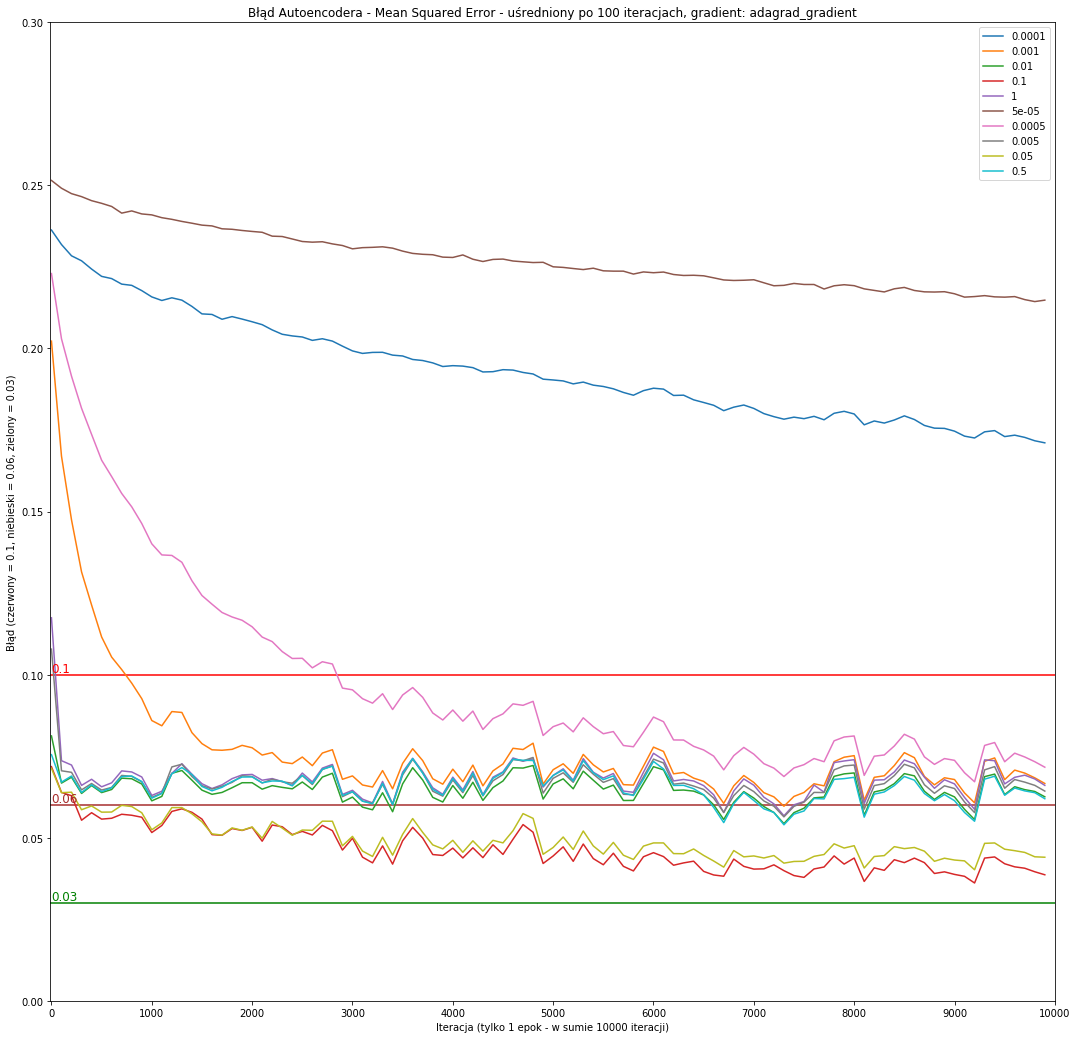

In [87]:
myresults=np.asarray(aedificator_mundi_carcerem).reshape(lf, lr, epokz*iterr)
#dt - liczba iteracji, kgbo - uśrednienie błędu po tylu iteracjach, ss- parametr labeli
dt=iterr*epokz
kgbo=100
dt2=dt//kgbo
ss=10
alpha, beta, gamma=0.1,0.06,0.03

for i in range(myresults.shape[0]):
    fig, ax=plt.subplots(1, 1, figsize=(18,18))
    
    det=re.search('on.*at', str(funlist[i])).span()
    det2=str(funlist[i])[det[0]+3:det[1]-3]
    
    ax.set_title('Błąd Autoencodera - Mean Squared Error - uśredniony po {} iteracjach, gradient: {}'.format(kgbo, det2))
    ax.set_xlabel('Iteracja (tylko {} epok - w sumie {} iteracji)'.format(epokz, dt))
    ax.set_xticklabels(range(0, dt+1, kgbo*ss))
    ax.set_xticks(range(0, dt//kgbo+1, ss))
    ax.set_ylabel('Błąd (czerwony = {}, niebieski = {}, zielony = {})'.format(alpha, beta, gamma))
    ax.axhline(alpha, color='red')
    ax.axhline(beta, color='brown')
    ax.axhline(gamma, color='green')
    
    ax.text(x=0, y=alpha, s='{}'.format(alpha), verticalalignment='bottom', horizontalalignment='left', color='red', size=12)
    ax.text(x=0, y=beta, s='{}'.format(beta), verticalalignment='bottom', horizontalalignment='left', color='brown', size=12)
    ax.text(x=0, y=gamma, s='{}'.format(gamma), verticalalignment='bottom', horizontalalignment='left', color='green', size=12)
    ax.set_ylim(0, 0.3)
    ax.set_xlim(-0.1, dt2)
    
    for j in range(myresults.shape[1]):
        #Formulacja średnich
        dkkk=[0]*dt2
        for jj in range(dt2):
            dkkk[jj]=sum(myresults[i,j,jj*kgbo:(jj+1)*kgbo])/kgbo

        ax.plot(dkkk, label=str(rfun[j]))
        
    ax.legend()
    plt.show()

In [45]:
det=re.search('on.*at', str(funlist[0])).span()
print(str(funlist[0])[det[0]+3:det[1]-3])

nestorov_accelerated_gradient


In [52]:
print(summerland[1])

[[2.86069796e-03 5.82492830e-03 7.62844251e-04 8.06292246e-03
  7.60968719e-03 2.91514866e-03 1.15925257e-03 6.09411888e-04
  4.87603464e-04 1.02215174e-02 4.26123854e-04 6.40887135e-04
  8.22891509e-04 3.29050849e-03 2.90736423e-03 9.07107076e-05
  1.49730688e-04 1.24199018e-03 7.91685441e-03 7.82530639e-06
  9.83784157e-03 1.28109059e-03 1.86561017e-03 1.10034166e-04
  2.06921007e-03 6.77264528e-04 6.99129697e-03 9.22294747e-03
  7.15288241e-03 9.02804964e-04 8.83103681e-03 6.79277121e-03
  1.42772318e-04 1.00599887e-03 9.23213002e-03 3.16932519e-03
  7.83838638e-03 2.92380717e-03 2.53819177e-03 2.74967601e-03
  6.57088935e-04 6.96951437e-03 4.87331710e-03 9.26735608e-03
  3.44567144e-04 8.64817112e-04 1.20923973e-04 8.11539398e-04
  7.95561107e-03 8.21989788e-04]
 [5.84586394e-04 1.19032973e-03 1.55887960e-04 1.64766600e-03
  1.55504693e-03 5.95713447e-04 2.36894382e-04 1.24533908e-04
  9.96422392e-05 2.08877696e-03 8.70788214e-05 1.30965906e-04
  1.68158675e-04 6.72418590e-04 5.941

In [81]:
j, i1=1, 4
argnamez=funlist[i1].__code__.co_varnames[:funlist[i1].__code__.co_argcount]

t1=time.time()
for i in range(0, 1, 1):
    nwlst=[]
    for jj in range(len(argnamez)):
        exec('nwlst.append({})'.format(mydick[argnamez[jj]]))
    print(nwlst)
t2=time.time()
print(t2-t1)
#weight_delta[j-1]=funlist[i1](*nwlst)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 0.5, matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), 1e-08]
0.0
